# 23andMe: Sales Data Analysis

**Leng Yang**

**Last Updated: 1/27/25**

## Assignment

Project Source: https://platform.stratascratch.com/data-projects/sales-data-analysis

Please answer the questions below based on the data provided:

1. Plot daily sales for all 50 weeks.
2. It looks like there has been a sudden change in daily sales. What date did it occur?
3. Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?
4. Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).
5. Assume a given day is divided into four dayparts: What is the percentage of sales in each daypart over all 50 weeks?
    * night (12:00AM - 6:00AM)
    * morning (6:00AM - 12:00PM)
    * afternoon (12:00PM - 6:00PM)
    * evening (6:00PM - 12:00AM)

## Data Description

The datasets/ directory contains fifty CSV files (one per week) of timestamped sales data. Each row in a file has two columns:
* `sale_time` - The timestamp on which the sale was made e.g. 2012-10-01 01:42:22
* `purchaser_gender` - The gender of the person who purchased (male or female)

<BR><BR>

### 1. Plot daily sales for all 50 weeks

In [6]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import glob

In [7]:
#Add files into a list
filenames = glob.glob('./datasets/*.csv')

#Create a dataframe from all files
df = pd.concat([pd.read_csv(name) for name in filenames])

In [8]:
#Inspect dataframe
print(df.shape)
df.head()

(204329, 2)


,sale_time,purchaser_gender
0,2012-10-01 01:42:22,female
1,2012-10-01 02:24:53,female
2,2012-10-01 02:25:40,female
3,2012-10-01 02:30:42,female
4,2012-10-01 02:51:32,male


In [9]:
#Extract sale date from datetime info and convert relevant columns to the correct data type
df['sale_date'] = pd.to_datetime(df['sale_time']).dt.date
df.sale_time = pd.to_datetime(df.sale_time)
df.sale_date = pd.to_datetime(df.sale_date)

df.head()

,sale_time,purchaser_gender,sale_date
0,2012-10-01 01:42:22,female,2012-10-01
1,2012-10-01 02:24:53,female,2012-10-01
2,2012-10-01 02:25:40,female,2012-10-01
3,2012-10-01 02:30:42,female,2012-10-01
4,2012-10-01 02:51:32,male,2012-10-01


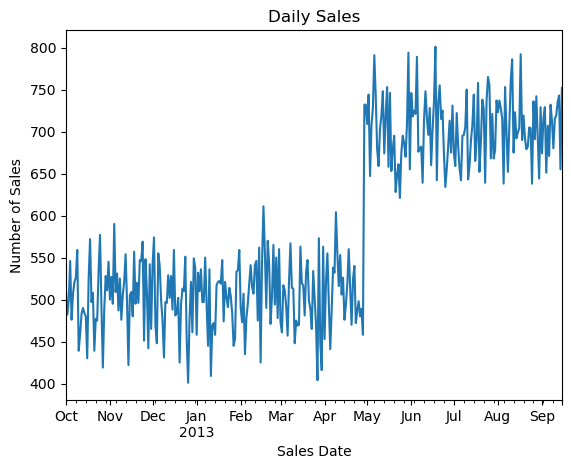

In [10]:
#Create dataframe of sales data
df_sales_num = pd.DataFrame(df.sale_date.value_counts().sort_index())

#Plot sales by date
df_sales_num.plot(legend=None)
plt.title('Daily Sales')
plt.xlabel('Sales Date')
plt.ylabel('Number of Sales');

<BR>

### 2. It looks like there has been a sudden change in daily sales. What date did it occur?

In [13]:
df_sales_num.rename(columns={'count':'num_sale'}, inplace=True)
df_sales_num['prev_day_sale'] = df_sales_num['num_sale'].shift(1)
df_sales_num['sale_diff'] = df_sales_num['num_sale'] - df_sales_num.prev_day_sale

df_sales_num.head()

,num_sale,prev_day_sale,sale_diff
sale_date,,,
2012-10-01,514,NaN,NaN
2012-10-02,482,514.0,-32.0
2012-10-03,499,482.0,17.0
2012-10-04,546,499.0,47.0
2012-10-05,476,546.0,-70.0


In [14]:
#Select that date where the largest change in sales occurred
df_sales_num.sale_diff.idxmax()

Timestamp('2013-04-29 00:00:00')

In [15]:
#Verify change by looking at a range of dates
df_sales_num['2013-04-27':'2013-05-01']

,num_sale,prev_day_sale,sale_diff
sale_date,,,
2013-04-27,489,480.0,9.0
2013-04-28,458,489.0,-31.0
2013-04-29,732,458.0,274.0
2013-04-30,732,732.0,0.0
2013-05-01,709,732.0,-23.0


<BR>

### 3. Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?

In [18]:
# Perform one-sample t-test to determine if the change in sales is statistically significant
#Drop null value in sale_diff column to get correct computations
t, p = stats.ttest_1samp(df_sales_num.sale_diff.dropna(), df_sales_num.loc['2013-04-29', 'sale_diff'])

#A very small p-value, less than 0.05, indicates the change is statistically significant
print('T-statistic:', t)
print('P-value:', p)

T-statistic: -88.84860321865489
P-value: 3.0520000042500664e-241


<BR>

### 4. Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).

In [21]:
#Create a dataframe to hold the daily sales for each gender
df_gender_sales = df.groupby(['sale_date'])['purchaser_gender'].value_counts().unstack()
df_gender_sales.head()

purchaser_gender,female,male
sale_date,,
2012-10-01,413,101
2012-10-02,379,103
2012-10-03,386,113
2012-10-04,432,114
2012-10-05,368,108


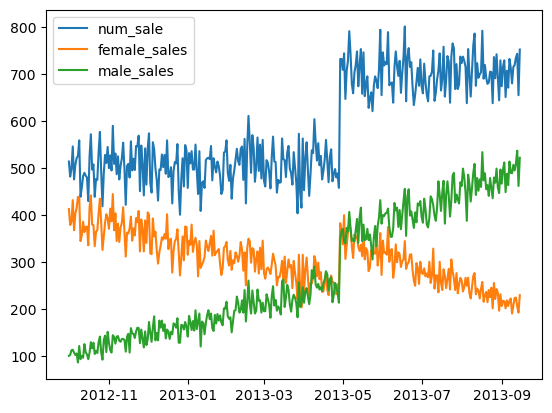

In [22]:
#Add gender sales to df_sales_num in order to plot and analyze the data
df_sales_num['female_sales'] = df_gender_sales.female
df_sales_num['male_sales'] = df_gender_sales.male

#Plot total sales and sales for each gender -- the data suggests that the change in sales is NOT due to a shift in proportion of the customer genders
for col in ['num_sale','female_sales','male_sales']:
    plt.plot(df_sales_num.index, df_sales_num[col], label=col)
plt.legend(loc='upper left');

<BR>

### 5. Assume a given day is divided into four dayparts: What is the percentage of sales in each daypart over all 50 weeks?
* night (12:00AM - 6:00AM)
* morning (6:00AM - 12:00PM)
* afternoon (12:00PM - 6:00PM)
* evening (6:00PM - 12:00AM)

In [25]:
#Create bins and labels for each day part
bins = [0, 6, 12, 18, 24]
labels = ['night', 'morning', 'afternoon', 'evening']

#Create new column containing the day parts
df['day_part'] = pd.cut(df.sale_time.dt.hour, bins=bins, labels=labels, right=False)
df.head()

,sale_time,purchaser_gender,sale_date,day_part
0,2012-10-01 01:42:22,female,2012-10-01,night
1,2012-10-01 02:24:53,female,2012-10-01,night
2,2012-10-01 02:25:40,female,2012-10-01,night
3,2012-10-01 02:30:42,female,2012-10-01,night
4,2012-10-01 02:51:32,male,2012-10-01,night


In [27]:
#Get percentage of sales for each day part
df.day_part.value_counts(normalize=True) * 100

day_part
afternoon    39.413397
morning      30.769005
evening      20.858517
night         8.959081
Name: proportion, dtype: float64